<a href="https://colab.research.google.com/github/Phatdeluxe/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

### Importing stuff

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [211]:
df['SALE_PRICE'].value_counts()

0           6909
10           199
800000       125
750000       121
650000       120
550000       117
450000       117
400000       107
700000       106
600000       105
500000       104
950000        95
850000        92
1200000       92
900000        89
300000        85
1500000       85
350000        80
525000        77
1300000       77
250000        76
1100000       73
625000        69
1250000       65
575000        63
520000        62
560000        61
675000        60
490000        60
480000        59
            ... 
1324577        1
634370         1
8850000        1
491000         1
1367500        1
597444         1
380350         1
646588         1
2670000        1
206435         1
691814         1
18007663       1
612013         1
393000         1
216500         1
515510         1
2162440        1
499412         1
5093057        1
1720000        1
1404586        1
319100         1
314820         1
382621         1
2743750        1
5236177        1
229000         1
397218        

# My work

## Preparing the data

In [212]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df_copy = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df_copy = df_copy[df_copy['SALE_PRICE'] < 2000000]
df_copy = df_copy[df_copy['SALE_PRICE'] > 100000]
df_copy = df_copy.drop(['EASE-MENT'], axis=1)

In [214]:
df_copy['SALE_PRICE'].value_counts()

500000     48
550000     43
450000     40
525000     40
650000     36
700000     35
600000     33
400000     33
800000     28
520000     28
480000     25
490000     25
850000     25
560000     25
575000     24
350000     24
510000     23
610000     23
470000     23
540000     23
515000     22
465000     22
900000     22
625000     21
750000     20
580000     20
640000     20
475000     20
485000     19
440000     19
           ..
628900      1
719000      1
657558      1
1530000     1
444558      1
948500      1
587400      1
266667      1
276822      1
473500      1
945000      1
375180      1
452998      1
346500      1
133500      1
838000      1
518500      1
948578      1
1158000     1
756000      1
768328      1
248132      1
486000      1
728000      1
371000      1
413000      1
672045      1
457000      1
608550      1
727000      1
Name: SALE_PRICE, Length: 1000, dtype: int64

In [0]:
train = df_copy[df_copy['SALE_DATE'].dt.month < 4]
test = df_copy[df_copy['SALE_DATE'].dt.month == 4]

In [216]:
train['SALE_DATE'].describe()

count                    2507
unique                     68
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-03-30 00:00:00
Name: SALE_DATE, dtype: object

In [217]:
test['SALE_DATE'].describe()

count                     644
unique                     23
top       2019-04-15 00:00:00
freq                       43
first     2019-04-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [218]:
test['SALE_PRICE'].mean()

655757.054347826

## Removing high cardinality, and 1 unique features

In [219]:
df_copy.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [220]:
df_copy.describe(include=object)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE
count,3151,3151,3151,3151,3151,3151,1,3151,3151
unique,5,7,1,2,13,3135,1,1035,11
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,117-45 125TH STREET,RP.,"4,000",A1
freq,1580,2959,3151,3111,1185,2,1,289,1186


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'APARTMENT_NUMBER',
                    'LAND_SQUARE_FEET', 'SALE_DATE',
                    'BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER',
                    'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE',
                    'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [222]:
y_train

44        550000
61        200000
78        810000
108       125000
111       620000
120      1150000
121       836500
132       955000
137       820000
141       980000
150       430000
155       700000
156       448000
157       670000
160      1390000
162       540000
176       520000
178       480000
180       570000
184       552000
185       505000
186       357500
193       670000
267       549000
282       970000
284       800000
289       450000
296       330000
297       575000
304       450000
          ...   
18034     675000
18037     463146
18038     354500
18052     240000
18075     585000
18083     395000
18085     425000
18086     540000
18095     417000
18097     444558
18101     267000
18102     412600
18105     537500
18107     541709
18110    1053000
18111     760000
18112     540000
18114     570000
18116     130000
18117     465000
18120     535000
18123     520000
18124     515000
18125     475000
18128     500000
18129     330000
18130     690000
18132     6109

## One Hot Encoding

In [239]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train.shape

(2507, 20)

In [240]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5495,801,11230.0,1.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,0,1,0,7918,72,11427.0,1.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,0,1,0,4210,19,10461.0,1.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5212,69,11226.0,1.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7930,121,11203.0,1.0,1940.0,1


## Selecting features with SelectKBest

In [244]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2507, 10), (644, 10))

In [245]:
X_train_selected.shape

(2507, 10)

In [246]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
  print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
  print(name)

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BLOCK
ZIP_CODE


Features not selected:
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


## fitting ridge regression

In [228]:
import math

train['SALE_PRICE'].mean()

621573.7423214999

In [247]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Linear regression for SelectKBest features
lin_reg = LinearRegression()
lin_reg.fit(X_train_selected, y_train)
print(f'MSE: {mean_squared_error(y_test, lin_reg.predict(X_test_selected))}')
print(f'MAE: {mean_absolute_error(y_test, lin_reg.predict(X_test_selected))}')

MSE: 67957983559.42586
MAE: 182030.0444301178


In [248]:
from sklearn.linear_model import Ridge

# Ridge regression for SelectKBest features
ridge_reg = Ridge(alpha=1).fit(X_train_selected, y_train)
print(f'MSE: {mean_squared_error(y_test, ridge_reg.predict(X_test_selected))}')
print(f'MAE: {mean_absolute_error(y_test, ridge_reg.predict(X_test_selected))}')

MSE: 68246010052.06883
MAE: 182531.53280755985


In [249]:
# Ridge regression for all features
ridge_reg = Ridge(alpha=1).fit(X_train, y_train)
print(f'MSE: {mean_squared_error(y_test, ridge_reg.predict(X_test))}')
print(f'MAE: {mean_absolute_error(y_test, ridge_reg.predict(X_test))}')

MSE: 69696731626.88936
MAE: 183634.55720997837


In [232]:
# MSE and MAE vs SALE_PRICE mean
sale_price_mean = []
for _ in y_test:
  sale_price_mean.append(train['SALE_PRICE'].mean())

print(f'MSE: {mean_squared_error(y_test, sale_price_mean)}')
print(f'MAE: {mean_absolute_error(y_test, sale_price_mean)}')

MSE: 89228639961.4915
MAE: 211564.20053849227


## Standardize data

In [0]:
# from sklearn.preprocessing import scale

# X_train_scaled = 

In [0]:
alphas = []
mses = []
maes = []

for alpha in range(1, 2000, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    mae = mean_absolute_error(y_test, ridge_reg_split.predict(X_test))
    # print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)
    maes.append(mae)

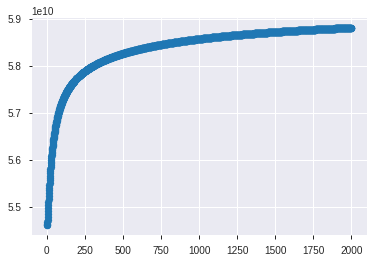

In [235]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

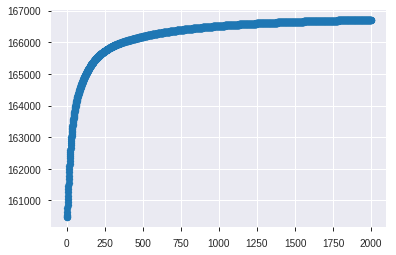

In [236]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, maes);